# 🧠 [MLSP 2014 Schizophrenia Classification Challenge](https://www.kaggle.com/competitions/mlsp-2014-mri/overview) — A Guided Tutorial

Welcome to this hands-on tutorial! In this notebook, we will walk step-by-step through the process of **loading, exploring, and modeling** the MLSP 2014 Schizophrenia dataset with a Graph Neural Network (GNN).

Our goals:
1. Understand the dataset structure and the meaning of FNC & SBM features.
2. Perform exploratory data analysis (EDA) to uncover patterns and insights.
3. Prepare the data for graph-based deep learning.
4. Build and train a GNN for classification.
5. Evaluate the results and discuss next steps.

> 💡 **Tip:** Treat this notebook as a guided workshop. Each section will include explanations of *what*, *why*, and *how* we perform each step.

---

## **1. Understanding the Dataset**

We will start by exploring the dataset and its features.


### 1.1 Feature Types: FNC & SBM

The dataset contains two main feature sets derived from MRI data:

**FNC Features (Functional Network Connectivity):**
- Represent pairwise correlations between ICA brain maps (nodes).
- Well-suited as *edge weights* in a brain connectivity graph.
- Capture functional relationships between brain regions.

**SBM Features (Source-Based Morphometry):**
- Represent loadings of ICA components for each subject.
- Can be used as *node-level features* describing the gray matter concentration of brain regions.

<p align="center">
<img src="images/brain.png" width="600">
</p>

*Image credit: Chu, SH., Parhi, K.K. & Lenglet, C. Function-specific and Enhanced Brain Structural Connectivity Mapping via Joint Modeling of Diffusion and Functional MRI. Sci Rep 8, 4741 (2018). https://doi.org/10.1038/s41598-018-23051-9

> 💡 **Why it matters:** In a GNN context, FNC features model the relationships between nodes, while SBM features describe the nodes themselves.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotly.graph_objects as go
import random
import seaborn as sns


import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import NNConv, global_mean_pool

### 2.1 Loading the Dataset

We will begin by reading the CSV files into pandas DataFrames.  
This allows us to explore the structure, inspect the columns, and perform basic EDA.


In [3]:
# Load subject data
fnc_df = pd.read_csv("data/train_FNC.csv")
labels_df = pd.read_csv("data/train_labels.csv")
node_df= pd.read_csv("data/train_node.csv") #self label data from images PDF
sbm_df = pd.read_csv("data/train_SBM.csv") 

# Load the FNC edge-to-node mapping
fnc_map = pd.read_csv("data/AdditionalInformation/rs_fMRI_FNC_mapping.csv")

# Create 0-based node indexing, dataset has nodes that are non-consecutive
unique_nodes = pd.unique(fnc_map[['mapA', 'mapB']].values.ravel())
unique_nodes.sort()
node_id_map = {orig: idx for idx, orig in enumerate(unique_nodes)}

# Apply mapping to edge definitions
fnc_map['node1'] = fnc_map['mapA'].map(node_id_map)
fnc_map['node2'] = fnc_map['mapB'].map(node_id_map)

# Extract edge list

edge_index_list = fnc_map[['node1', 'node2']].values
reversed_edges = edge_index_list[:, [1, 0]]
combined_edges = np.vstack([edge_index_list, reversed_edges]).T
edge_index = torch.tensor(combined_edges, dtype=torch.long)

# edge_index_list = fnc_map[['node1', 'node2']].values.T  
# edge_index = torch.tensor(edge_index_list, dtype=torch.long)

node_df = node_df.sort_values("Node").reset_index(drop=True)
node_features = torch.tensor(node_df[['x', 'y', 'z']].values, dtype=torch.float) 

data_df = fnc_df.merge(labels_df, on="Id")

<Axes: xlabel='Class', ylabel='count'>

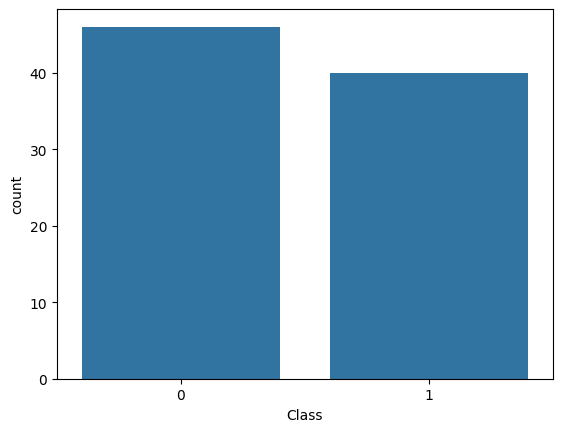

In [5]:
sns.countplot(data=labels_df, x="Class")

### 2.2 Class Balance Check

Before building a model, it’s important to check the distribution of the target classes.  
Here, we observe **no significant class imbalance**, meaning the classes are roughly equally represented.

> ✅ **Why it's good:** Balanced classes simplify model training and reduce the need for resampling techniques.


### **2.3 Creating Graph Data with `torch_geometric.data.Data`**

In this step, we transform each patient’s brain imaging data into a **graph representation** using PyTorch Geometric’s `Data` object.

**Concept:**
- **One patient = one graph**.
- **Nodes** → Brain maps derived from **Independent Component Analysis (ICA)** of Functional Network Connectivity (FNC) data.
- **Node features** → The *(x, y, z)* spatial coordinates of each brain region.
- **Edges** → Functional connections between brain maps.
- **Edge features** → Correlation values from FNC.
- **Global graph-level features** → Structural Brain Morphometry (SBM) data, stored separately and **not connected to any node**.

**Process:**
1. Loop through each patient’s record in the dataframe.
2. Extract **FNC correlation values** and use them as edge attributes.
3. Retrieve **SBM values** for the subject and store them as a separate tensor.
4. Build a PyTorch Geometric `Data` object with:
   - `x`: Node feature matrix (spatial info)
   - `edge_index`: Graph connectivity
   - `edge_attr`: Correlation strengths
   - `y`: Target label (class)
   - `sbm`: Global SBM vector
5. Save the patient’s graph in a list for later use in training.

> 💡 **Why this structure?**  
> This separation of node-level, edge-level, and graph-level features lets the GNN leverage **both functional and structural brain information** effectively.

In [4]:
graphs = []

for _, row in data_df.iterrows():
    subject_id = row["Id"]
    label = row["Class"]

    fnc_values = row.filter(like="FNC").values
    edge_attr = torch.tensor(fnc_values, dtype=torch.float).view(-1, 1)
    edge_attr = torch.cat([edge_attr, edge_attr], dim=0)  # now [756, 1] for undirected

    sbm_vector = sbm_df.loc[sbm_df["Id"] == subject_id].drop(columns=["Id"]).values.flatten()
    sbm_tensor = torch.tensor(sbm_vector, dtype=torch.float).view(1, -1)  # shape [1, 32]
 
    graph = Data(
        x=node_features.clone(),
        edge_index=edge_index,
        edge_attr=edge_attr,
        y=torch.tensor([label], dtype=torch.long),
        sbm=sbm_tensor
    )
    graph.subject_id = subject_id
    graphs.append(graph)

In [5]:
print(graphs[2])

Data(x=[28, 3], edge_index=[2, 756], edge_attr=[756, 1], y=[1], sbm=[1, 32], subject_id=139149.0)


### **2.4 (Optional) Visualizing the Brain Graph with Plotly**

To better understand the spatial and connectivity structure of our brain graphs,  
we can create an **interactive 3D visualization** using **Plotly**.

**How it works:**
- **Nodes** → Plotted at their *(x, y, z)* spatial coordinates (from ICA brain maps).
- **Edges** → Drawn between nodes to represent functional connections.
- **Edge color**:
  - **Blue** → Positive correlation.
  - **Red** → Negative correlation.
  - **Light gray** → Weak connection (below a set threshold).
- **Edge thickness** → Increases with correlation strength.

**Function Parameters:**
- `graph` → A `torch_geometric.data.Data` object for a single patient.
- `title` → Optional title for the plot.
- `edge_threshold` → Minimum absolute correlation value to highlight an edge.

> 💡 **Why visualize?**  
> Plotting the graph makes it easier to interpret which brain regions are strongly connected  
> and whether there are visible structural differences between healthy and schizophrenia-affected patients.

In [6]:
def plot_3d_brain_graph_plotly(graph, title=None, edge_threshold=0.1):
    coords = graph.x.numpy()          # [28, 3]
    edge_index = graph.edge_index.T   # [378, 2]
    edge_weights = graph.edge_attr.numpy().flatten()

    # Prepare edge traces
    edge_lines = []
    edge_colors = []
    for i, (src, tgt) in enumerate(edge_index):
        w = edge_weights[i]

        if abs(w) < edge_threshold:
            color = 'lightgray'
        elif w > 0:
            color = 'blue'
        else:
            color = 'red'

        x0, y0, z0 = coords[src]
        x1, y1, z1 = coords[tgt]
        edge_lines.append(go.Scatter3d(
            x=[x0, x1, None],
            y=[y0, y1, None],
            z=[z0, z1, None],
            mode='lines',
            line=dict(color=color, width=4 if abs(w) > edge_threshold else 2),
            hoverinfo='none',
            showlegend=False
        ))

    # Node trace
    node_trace = go.Scatter3d(
        x=coords[:, 0],
        y=coords[:, 1],
        z=coords[:, 2],
        mode='markers',
        marker=dict(size=6, color='skyblue'),
        name='ICA Nodes',
        hoverinfo='text'
    )

    # Create figure
    fig = go.Figure(data=[*edge_lines, node_trace])

    fig.update_layout(
        title=title or f"3D Brain Graph - Label: {graph.y.item()}",
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
        ),
        margin=dict(l=0, r=0, b=0, t=40),
        showlegend=True
    )

    fig.show()

In [7]:
i= 6
plot_3d_brain_graph_plotly(
    graphs[i],
    title=f"Subject {graphs[i].subject_id}, Label {graphs[i].y.item()}",
    edge_threshold=0
)

In [ ]:
# Definining a seed for the enviroment 
def set_seed(seed=32):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Make deterministic
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    os.environ["PYTHONHASHSEED"] = str(seed)

### 2.5 Train_Test Split and Dataloader

In [9]:
# Extract labels for stratification
labels = [g.y.item() for g in graphs]

# Stratified split
train_graphs, test_graphs = train_test_split(
    graphs, test_size=0.2, stratify=labels, random_state=42
)

In [10]:
# Create batched loaders
train_loader = DataLoader(train_graphs, batch_size=4, shuffle=True)
test_loader = DataLoader(test_graphs, batch_size=4, shuffle=False)

## 3 GNN Architecture and Training
---
### 3.1 GNN Architecture

Before diving into code, let's visualize the architecture we'll use for classification.

```markdown
Node features (x) ─────┐
Edge features          │
Edge index             ▼
         ┌───────────────┐
         │  NNConv + ReLU│  (x: [num_nodes, 3] → [num_nodes, 64])
         └───────────────┘
                      ↓
         ┌───────────────┐
         │  NNConv + ReLU│  (x: [num_nodes, 64] → [num_nodes, 64])
         └───────────────┘
                      ↓
         ┌─────────────────────┐
         │ global_mean_pool    │  (→ [batch_size, 64])
         └─────────────────────┘
                      ↓
SBM (→ [batch_size, 32]) → concat → [batch_size, 96]
                      ↓
         ┌─────────────────────┐
         │ Dropout + Classifier│ → [batch_size, 2]
         └─────────────────────┘
```

> 💡 **Tip:** The pooling layer aggregates node information into a graph-level representation, which is crucial for classification tasks.


In [30]:
class GNNWithEdgeAttrsAndSBM(nn.Module):
    def __init__(self, in_channels=3, edge_dim=1, sbm_dim=32, hidden_dim=64):
        super().__init__()
        
        # First NNConv layer
        self.edge_nn1 = nn.Sequential(
            nn.Linear(edge_dim, 32),
            nn.ReLU(),
            nn.Linear(32, in_channels * hidden_dim)
        )
        self.conv1 = NNConv(in_channels, hidden_dim, self.edge_nn1, aggr='max')
        self.bn1 = nn.BatchNorm1d(hidden_dim)

        # Second NNConv layer
        self.edge_nn2 = nn.Sequential(
            nn.Linear(edge_dim, 32),
            nn.ReLU(),
            nn.Linear(32, hidden_dim * hidden_dim)
        )
        self.conv2 = NNConv(hidden_dim, hidden_dim, self.edge_nn2, aggr='max')
        self.bn2 = nn.BatchNorm1d(hidden_dim)

        # Final classifier takes graph embedding + SBM vector
        self.dropout = nn.Dropout(p=0.3)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim + sbm_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        sbm = data.sbm
        # if sbm.dim() == 1:
            # sbm = sbm.unsqueeze(0)  # ensure batch dim

        # GNN layers
        x = F.relu(self.bn1(self.conv1(x, edge_index, edge_attr)))
        x = F.relu(self.bn2(self.conv2(x, edge_index, edge_attr)))

        # Graph-level embedding
        x = global_mean_pool(x, batch)

        # Concatenate SBM global features
        x = torch.cat([x, sbm], dim=1)

        x = self.dropout(x)
   
        return self.classifier(x)

### **3.2 Training Setup for the GNN**

Before we train, we’ll configure the **device**, **model**, **optimizer**, and **loss**.

**What we’re doing:**
- **Device selection**: Use GPU (`cuda`) or MPS (`mps`)if available for faster training; otherwise fall back to CPU.
- **Model init**: `GNNWithEdgeAttrsAndSBM` takes:
  - `in_channels=3` → each node has 3D spatial coordinates (x, y, z).
  - `edge_dim=1` → each edge carries a single FNC correlation value.
- **Optimizer**: Adam with a conservative learning rate (`1e-4`) for stable convergence.
- **Loss function**: Cross-entropy for binary/multi-class classification.


In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")
model = GNNWithEdgeAttrsAndSBM(in_channels=3, edge_dim=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()


# Global lists to log performance
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []


def train():
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        pred = out.argmax(dim=1)
        correct += (pred == data.y).sum().item()
        total += data.num_graphs

    acc = correct / total
    train_losses.append(total_loss / len(train_loader))
    train_accuracies.append(acc)
    return acc


def test(loader, is_test=True):
    model.eval()
    total_loss = 0
    correct = 0
    all_preds = []
    all_labels = []

    for data in loader:
        data = data.to(device)
        out = model(data)
        loss = criterion(out, data.y)
        total_loss += loss.item()

        pred = out.argmax(dim=1)
        correct += (pred == data.y).sum().item()

        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(data.y.cpu().numpy())

    acc = correct / len(loader.dataset)
    if is_test:
        test_losses.append(total_loss / len(loader))
        test_accuracies.append(acc)
    return acc, all_preds, all_labels

In [32]:
for epoch in range(1, 51):
    train_acc = train()
    test_acc, test_preds, test_labels = test(test_loader)

    print(f"Epoch {epoch:02d} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")

Epoch 01 | Train Acc: 0.4853 | Test Acc: 0.5556
Epoch 02 | Train Acc: 0.5147 | Test Acc: 0.5556
Epoch 03 | Train Acc: 0.5294 | Test Acc: 0.6667
Epoch 04 | Train Acc: 0.5294 | Test Acc: 0.6667
Epoch 05 | Train Acc: 0.5588 | Test Acc: 0.6667
Epoch 06 | Train Acc: 0.6471 | Test Acc: 0.7222
Epoch 07 | Train Acc: 0.6176 | Test Acc: 0.7222
Epoch 08 | Train Acc: 0.7059 | Test Acc: 0.7222
Epoch 09 | Train Acc: 0.6765 | Test Acc: 0.7222
Epoch 10 | Train Acc: 0.6618 | Test Acc: 0.7778
Epoch 11 | Train Acc: 0.7941 | Test Acc: 0.8333
Epoch 12 | Train Acc: 0.7206 | Test Acc: 0.8333
Epoch 13 | Train Acc: 0.8382 | Test Acc: 0.8333
Epoch 14 | Train Acc: 0.8235 | Test Acc: 0.9444
Epoch 15 | Train Acc: 0.7794 | Test Acc: 0.9444
Epoch 16 | Train Acc: 0.7941 | Test Acc: 0.8889
Epoch 17 | Train Acc: 0.8382 | Test Acc: 0.8889
Epoch 18 | Train Acc: 0.8676 | Test Acc: 0.9444
Epoch 19 | Train Acc: 0.7941 | Test Acc: 0.9444
Epoch 20 | Train Acc: 0.8676 | Test Acc: 0.9444
Epoch 21 | Train Acc: 0.8088 | Test Acc:

---
### **3.3 Plotting Training Curves & Confusion Matrix**

Now that we’ve trained the model, let’s **visualize performance** to check learning dynamics and how well the classifier separates classes.

**What we plot:**
- **Loss curves** (train vs. test): reveals optimization progress and potential **over/underfitting**.
- **Accuracy curves** (train vs. test): shows predictive performance across epochs.
- **Confusion matrix** (on the test set): breaks down **true vs. predicted** counts per class, highlighting error patterns.

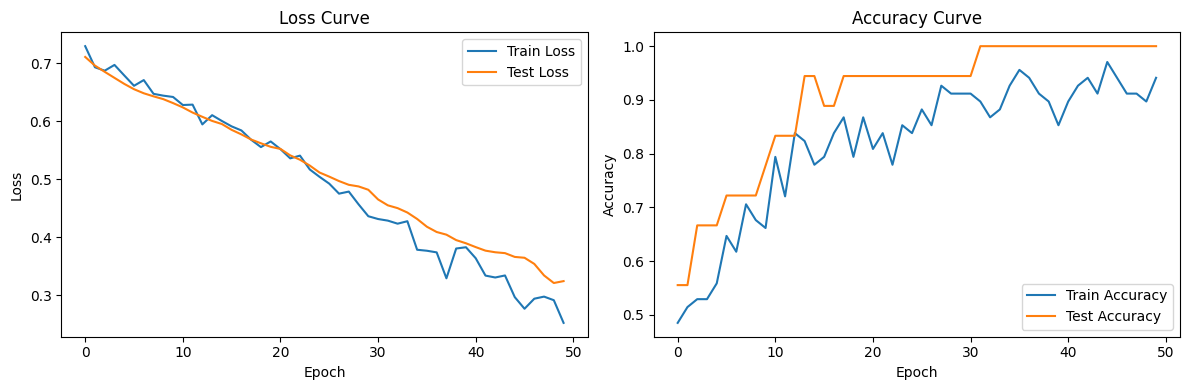

In [34]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title("Loss Curve")
plt.xlabel("Epoch")

plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

<Figure size 600x500 with 0 Axes>

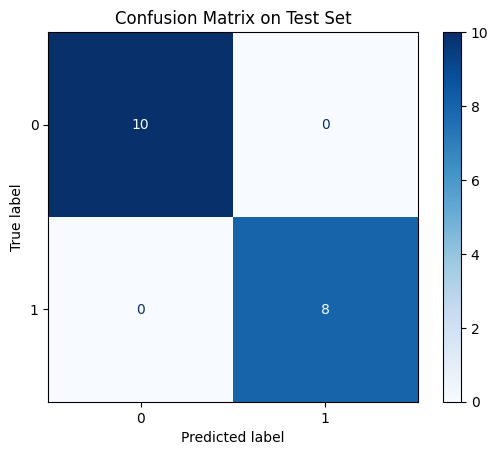

In [33]:
cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

plt.figure(figsize=(6, 5))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix on Test Set")
plt.show()

---

## 📊 4. Summary & Next Steps

In this tutorial, we:
- Explored the structure and meaning of FNC & SBM features.
- Checked class balance and basic dataset properties.
- Built a GNN architecture tailored for brain connectivity data.
- Trained and evaluated the model.

**Next steps you could try:**
1. Experiment with different pooling strategies (`global_max_pool`, `global_add_pool`).
2. Tune hyperparameters (learning rate, dropout, hidden sizes).
3. Try combining additional MRI-derived features for richer node descriptions.


## 5. Optional (Comparision with Random forest results)

Merged shape: (86, 34)
Features shape: (86, 32), Labels shape: (86,)

Accuracy: 0.8889
ROC-AUC: 0.9062

Classification Report:
              precision    recall  f1-score   support

           0     0.9000    0.9000    0.9000        10
           1     0.8750    0.8750    0.8750         8

    accuracy                         0.8889        18
   macro avg     0.8875    0.8875    0.8875        18
weighted avg     0.8889    0.8889    0.8889        18



<Figure size 500x400 with 0 Axes>

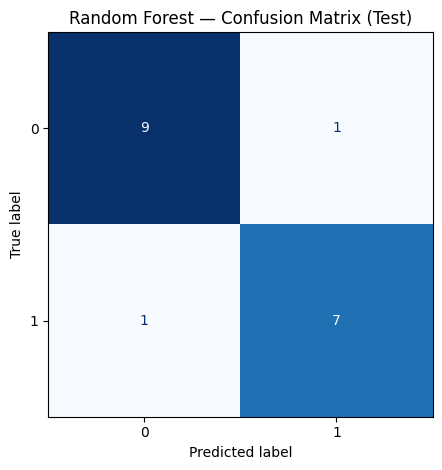

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score
)
import matplotlib.pyplot as plt

# --- CONFIG ---
RANDOM_STATE = 40
TEST_SIZE = 0.2
N_ESTIMATORS = 400
N_JOBS = -1  # use all cores

#  Merge SBM features with labels on 'Id' ---
# Assumptions:
#   - sbm_df: columns = ['Id', sbm_feature_1, sbm_feature_2, ..., sbm_feature_k]
#   - labels_df: columns = ['Id', 'Class']  (Class should be 0/1 or similar)
merged = pd.merge(sbm_df, labels_df, on="Id", how="inner")

# Drop any duplicate Ids if they exist (keeping the first)
merged = merged.drop_duplicates(subset=["Id"]).reset_index(drop=True)

# Separate features/labels
X = merged.drop(columns=["Id", "Class"])
y = merged["Class"].astype(int)  # ensure numeric

print(f"Merged shape: {merged.shape}")
print(f"Features shape: {X.shape}, Labels shape: {y.shape}")

#  Train/Test split (stratified) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)

#  Train Random Forest ---
rf = RandomForestClassifier(
    n_estimators=N_ESTIMATORS,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight=None,  
    n_jobs=N_JOBS,
    random_state=RANDOM_STATE
)
rf.fit(X_train, y_train)

#  Evaluate ---
y_pred = rf.predict(X_test)

# If binary labels, get probas for ROC-AUC; handle multi-class gracefully
try:
    y_proba = rf.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_proba)
except Exception:
    y_proba = None
    auc = None

acc = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {acc:.4f}")
if auc is not None:
    print(f"ROC-AUC: {auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
plt.figure(figsize=(5, 4))
disp.plot(cmap='Blues', values_format='d', colorbar=False)
plt.title("Random Forest — Confusion Matrix (Test)")
plt.tight_layout()
plt.show()
